## First model

In [4]:
import pandas as pd

from transformers import GPT2Tokenizer

from transformers import GPT2LMHeadModel
from torch.optim import AdamW

from transformers import get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm.notebook import tqdm
import json
from sklearn.model_selection import train_test_split
import os
from pathlib import Path

Load our data

In [5]:
data_path = Path(os.getcwd()).parent / 'data'

df = pd.read_csv(f'{data_path}/lyrics_filtered_768tokens.csv')

print(f"Loaded {len(df):,} songs")
print(f"Columns: {df.columns.tolist()}")
print(f"First row preview:")
print(df.iloc[0])

Loaded 39,415 songs
Columns: ['genre', 'lyrics', 'token_count', 'formatted_text']
First row preview:
genre                                                           Pop
lyrics            I feel so unsure\nAs I take your hand and lead...
token_count                                                     400
formatted_text    Genre: Pop\n\nI feel so unsure\nAs I take your...
Name: 0, dtype: object


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
print(device)
model_name = 'distilgpt2'
model_save_path = Path(os.getcwd()).parent / 'models'

cuda


In [7]:
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

print(f"Tokenizer loaded:")
print(f"Vocab size: {len(tokenizer):,}")
print(f"EOS token: '{tokenizer.eos_token}' ID: {tokenizer.eos_token_id}")
print(f"PAD token: '{tokenizer.pad_token}' ID: {tokenizer.pad_token_id}")

Tokenizer loaded:
Vocab size: 50,257
EOS token: '<|endoftext|>' ID: 50256
PAD token: '<|endoftext|>' ID: 50256


### Create the custom dataset

In [8]:
class LyricsDataset(Dataset):
    
    def __init__(self, formatted_texts, tokenizer, max_length=768):

        self.input_ids = []
        self.attn_masks = []
        
        print(f"Pre-tokenizing {len(formatted_texts)} songs...")
        for text in tqdm(formatted_texts):
            encodings = tokenizer.encode_plus(
                text,
                truncation=True,
                padding='max_length',
                max_length=max_length,
                return_tensors='pt'
            )
            self.input_ids.append(encodings['input_ids'].squeeze(0))
            self.attn_masks.append(encodings['attention_mask'].squeeze(0))
        
        print("Tokenization complete")
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attn_masks[idx],
            'labels': self.input_ids[idx]
        }


## Initialise the data

In [10]:

train_df, temp_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['genre'],
    random_state=6
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['genre'],
    random_state=6
)
# make sure there is no overlapp
train_df = train_df.drop_duplicates(subset="formatted_text")
val_df = val_df.drop_duplicates(subset="formatted_text")
test_df = test_df.drop_duplicates(subset="formatted_text")

val_df = val_df[~val_df["formatted_text"].isin(train_df["formatted_text"])]
test_df = test_df[~test_df["formatted_text"].isin(train_df["formatted_text"])]
test_df = test_df[~test_df["formatted_text"].isin(val_df["formatted_text"])]

In [11]:
train_dataset = LyricsDataset(train_df['formatted_text'].tolist(), tokenizer, 768)
val_dataset = LyricsDataset(val_df['formatted_text'].tolist(), tokenizer, 768)
test_dataset = LyricsDataset(test_df['formatted_text'].tolist(), tokenizer, 768)

Pre-tokenizing 31397 songs...


  0%|          | 0/31397 [00:00<?, ?it/s]

Tokenization complete
Pre-tokenizing 3905 songs...


  0%|          | 0/3905 [00:00<?, ?it/s]

Tokenization complete
Pre-tokenizing 3909 songs...


  0%|          | 0/3909 [00:00<?, ?it/s]

Tokenization complete


In [13]:
print(f"Dataset size: {len(train_dataset)}")
print(f"val Dataset size: {len(val_dataset)}")
print(f"test Dataset size: {len(test_dataset)}")
sample = train_dataset[0]
print(f"Sample shapes:")
print(f"input_ids: {sample['input_ids'].shape}")
print(f"attention_mask: {sample['attention_mask'].shape}")

Dataset size: 31397
val Dataset size: 3905
test Dataset size: 3909
Sample shapes:
input_ids: torch.Size([768])
attention_mask: torch.Size([768])


### Training LOOP

In [ ]:

def train_loop(model, optimizer, scheduler, train_loader, device, epoch, num_epochs):
    model.train()
    epoch_train_loss = 0
    batch_losses = []
    learning_rates = []
    print(f"Starting training epoch {epoch+1}/{num_epochs} with {len(train_loader)} batches")
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Training)")
    for batch in progress_bar:
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=input_ids
                )
                loss = outputs.loss

                batch_losses.append(loss)
                learning_rates.append(scheduler.get_last_lr()[0])
                epoch_train_loss += loss.item()

                #backprop
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                
                optimizer.step()
                scheduler.step()

                progress_bar.set_postfix({'train_loss': loss.item()})
                progress_bar.refresh()
            
            except RuntimeError as e:
                print(f"Error in training batch: {e}")
                raise
   
    return batch_losses, learning_rates

def validation_loop(model, val_loader, device, epoch, num_epochs):
        model.eval()
        batch_losses = []
        progress_bar =  tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)")
        with torch.no_grad():
            for batch in progress_bar:
                try:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)

                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=input_ids
                    )
                    batch_losses.append(outputs.loss.item())
                
                except RuntimeError as e:
                    print(f"Error in validation batch: {e}")
                    raise

        return batch_losses

def train_gpt2_model(
    model,
    train_loader,
    val_loader,
    device,
    optimizer,
    scheduler,
    num_epochs=3,
    patience=2,
    model_name="last_training"
    ):
    os.makedirs("./models", exist_ok=True)
    print('Using:', device)
    model = model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0
    history = {
        'train_loss_per_epoch': [],
        'val_loss_per_epoch': [],
        'train_loss_per_batch': [],
        'val_loss_per_batch': [],
        'learning_rates': [],
    }

    # Training loop
    for epoch in range(num_epochs):
        # Train
        epoch_train_losses, lrs = train_loop(model, optimizer, scheduler, train_loader, device, epoch, num_epochs)
        # save training data
        history['train_loss_per_batch'].extend(epoch_train_losses)
        history['learning_rates'].extend(lrs)
        avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
        print(f"Epoch {epoch + 1}/{num_epochs} - Avg Training Loss: {avg_train_loss:.4f}")
        history['train_loss_per_epoch'].append(avg_train_loss)

        # Val
        epoch_val_losses = validation_loop(model, val_loader, device, epoch, num_epochs)
        # save val data
        history['val_loss_per_batch'].extend(epoch_val_losses)
        avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
        history['val_loss_per_epoch'].append(avg_val_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}: Avg Validation Loss: {avg_val_loss:.4f}")

        # if we have not made the model better for two epochs, exit early
        if avg_val_loss < best_val_loss - 0.01:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"./models/{model_name}.pt")
            print(f'Saved best model checkpoint: epoch {epoch + 1}')
        else:
            patience_counter += 1
            print(f"Patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"Early stopping after epoch {epoch + 1}")
                break

    print("Done!")            
    return model, history
    

### Test with small dataset first!

In [ ]:
# get 10 procent of the data to test the training run
small_df, _ = train_test_split(
    df,
    train_size=0.1,
    stratify=df['genre'],
    random_state=6
)
print(f"Genre distribution:\n{small_df['genre'].value_counts()}")
BATCH_SIZE = 4
MAX_LENGTH = 512

small_train_df, small_val_df = train_test_split(
    small_df, 
    test_size=0.2, 
    stratify=small_df['genre'],
    random_state=6
)
small_train_dataset = LyricsDataset(small_train_df['formatted_text'].tolist(), tokenizer, MAX_LENGTH)
small_val_dataset = LyricsDataset(small_val_df['formatted_text'].tolist(), tokenizer, MAX_LENGTH)

small_train_loader = DataLoader(
    small_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=False
)

small_val_loader = DataLoader(
    small_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=False
)
LEARNING_RATE = 3e-5
NUM_EPOCHS = 2
WARMUP_STEPS = 500
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

small_model = GPT2LMHeadModel.from_pretrained(model_name)
model = small_model.to(device)

optimizer = AdamW(small_model.parameters(), lr=LEARNING_RATE, weight_decay= WEIGHT_DECAY)

total_steps = len(small_train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)
print(f"\n{'='*60}")
print("TRAINING CONFIGURATION")
print(f"{'='*60}")
print(f"Model: {model_name}")
print(f"Device: {device}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max length: {MAX_LENGTH}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Total steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")
print(f"{'='*60}")


Genre distribution:
genre
Heavy Metal    1337
Pop            1313
Indie          1291
Name: count, dtype: int64
Pre-tokenizing 3152 songs...


  0%|          | 0/3152 [00:00<?, ?it/s]

Tokenization complete
Pre-tokenizing 789 songs...


  0%|          | 0/789 [00:00<?, ?it/s]

Tokenization complete

TRAINING CONFIGURATION
Model: distilgpt2
Device: cuda
Batch size: 4
Max length: 512
Learning rate: 3e-05
Epochs: 2
Total steps: 1576
Warmup steps: 157


In [28]:
small_model, history = train_gpt2_model(small_model, small_train_loader, small_val_loader, device, optimizer, scheduler, num_epochs=NUM_EPOCHS)

Using: cuda
Starting training epoch 1/2 with 788 batches


Epoch 1/2 (Training):   0%|          | 0/788 [00:00<?, ?it/s]

Epoch 1/2 - Avg Training Loss: 2.0262


Epoch 1/2 (Validation):   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 1/2: Avg Validation Loss: 1.4825
Saved best model checkpoint: epoch 1
Starting training epoch 2/2 with 788 batches


Epoch 2/2 (Training):   0%|          | 0/788 [00:00<?, ?it/s]

Epoch 2/2 - Avg Training Loss: 1.5398


Epoch 2/2 (Validation):   0%|          | 0/198 [00:00<?, ?it/s]

Epoch 2/2: Avg Validation Loss: 1.4713
Saved best model checkpoint: epoch 2
Done!


 ### Big TF

In [ ]:
BATCH_SIZE = 8
MAX_LENGTH = 768
print(f"Genre distribution:{train_df['genre'].value_counts()}")
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=0,
    pin_memory=False
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
LEARNING_RATE = 3e-5
NUM_EPOCHS = 5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

larger_data_model = GPT2LMHeadModel.from_pretrained(model_name)
larger_data_model = larger_data_model.to(device)

optimizer = AdamW(larger_data_model.parameters(), lr=LEARNING_RATE, weight_decay= WEIGHT_DECAY)

total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)


Genre distribution:
genre
Heavy Metal    10702
Pop            10503
Indie          10327
Name: count, dtype: int64
Train batches: 3942
Val batches: 493


In [14]:
model2, big_history2 = train_gpt2_model(larger_data_model, train_loader, val_loader, device, optimizer, scheduler, num_epochs=NUM_EPOCHS, model_name='gpt2_retrained_good_split')

Using: cuda
Starting training epoch 1/5 with 3942 batches


Epoch 1/5 (Training):   0%|          | 0/3942 [00:00<?, ?it/s]

Epoch 1/5 - Avg Training Loss: 1.2424


Epoch 1/5 (Validation):   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 1/5: Avg Validation Loss: 0.9968
Saved best model checkpoint: epoch 1
Starting training epoch 2/5 with 3942 batches


Epoch 2/5 (Training):   0%|          | 0/3942 [00:00<?, ?it/s]

Epoch 2/5 - Avg Training Loss: 0.9956


Epoch 2/5 (Validation):   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 2/5: Avg Validation Loss: 0.9812
Saved best model checkpoint: epoch 2
Starting training epoch 3/5 with 3942 batches


Epoch 3/5 (Training):   0%|          | 0/3942 [00:00<?, ?it/s]

Epoch 3/5 - Avg Training Loss: 0.9761


Epoch 3/5 (Validation):   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 3/5: Avg Validation Loss: 0.9741
Patience counter: 1/2
Starting training epoch 4/5 with 3942 batches


Epoch 4/5 (Training):   0%|          | 0/3942 [00:00<?, ?it/s]

Epoch 4/5 - Avg Training Loss: 0.9646


Epoch 4/5 (Validation):   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 4/5: Avg Validation Loss: 0.9707
Saved best model checkpoint: epoch 4
Starting training epoch 5/5 with 3942 batches


Epoch 5/5 (Training):   0%|          | 0/3942 [00:00<?, ?it/s]

Epoch 5/5 - Avg Training Loss: 0.9579


Epoch 5/5 (Validation):   0%|          | 0/493 [00:00<?, ?it/s]

Epoch 5/5: Avg Validation Loss: 0.9687
Patience counter: 1/2
Done!


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

def to_cpu_floats(lst):
    return [x.detach().cpu().item() if hasattr(x, "detach") else float(x) for x in lst]


def create_poster_plots(history, save_dir='./plots'):
    
    os.makedirs(save_dir, exist_ok=True)

    for k, v in history.items():
        if isinstance(v, list):
            history[k] = to_cpu_floats(v)
            
    train_epoch = np.array(history['train_loss_per_epoch'])
    val_epoch   = np.array(history['val_loss_per_epoch'])

    fig, ax = plt.subplots(figsize=(8, 5))
    epochs = np.arange(1, len(train_epoch) + 1)

    ax.plot(epochs, train_epoch, '-o', color='#0072B2', linewidth=2.5, label='Train Loss')
    ax.plot(epochs, val_epoch, '-s', color='#D55E00', linewidth=2.5, label='Validation Loss')


    ax.fill_between(epochs, train_epoch, val_epoch, color='orange', alpha=0.15, label='Gap')

    ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11, loc='upper right', frameon=False)
    ax.set_title('Train vs Validation Loss', fontsize=14, fontweight='bold', pad=10)
   
    plt.tight_layout()
    plt.savefig(f'{save_dir}/poster_epoch_final_training.png', bbox_inches='tight')
    plt.show()



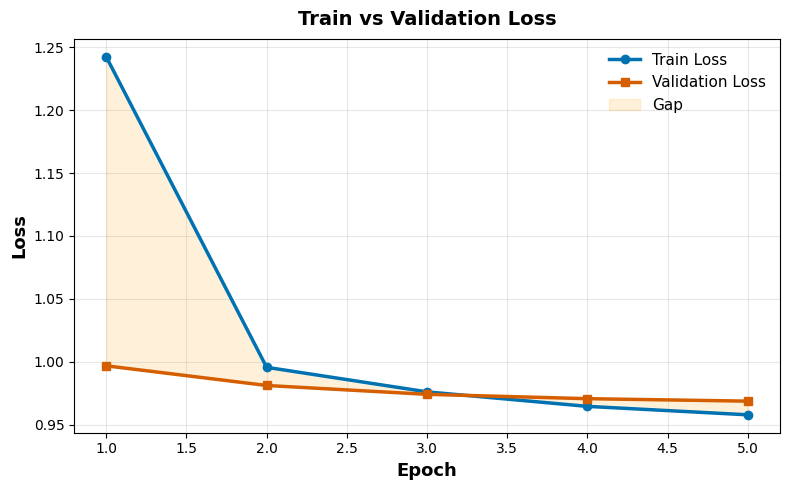

In [ ]:
create_poster_plots(big_history2)


#### Save the data for being to fix plots without gpu

In [ ]:


os.makedirs("./params", exist_ok=True)
os.makedirs("./data", exist_ok=True)

for k, v in big_history2.items():
    if isinstance(v, list):
        big_history2[k] = [float(x.detach().cpu()) if hasattr(x, "detach") else float(x) for x in v]

history_path = "./params/big_training_history.json"
with open(history_path, "w") as f:
    json.dump(big_history2, f, indent=2)
train_path = "./data/train_split.csv"
val_path   = "./data/val_split.csv"
test_path  = "./data/test_split.csv"

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)
